# Neural Network Implementation for Hand Written Digit classification

**Author - Chinmay Vadgama; ID : 014551407**

Instructions :
```
1. Implement Mini-Batch Gradient Descent
2. Implement drop-out regularization for all/some of the layers to see the impact of drop out technique
3. Initialize Random Weights 
4. Use Image Augmentation to achieve robustness and avoid overfitting
5. Try using multiple layers(more than 2) and experiment with number of layers and neurons
6. Use appropriate activation function such as RelU and Softmax
7. Scale/Normalize the input
8. Use different Learning rates/adaptive learning rate
9. The code should provide appropriate metrics, visualization,  testing and training accuracy etc.,. and plot the results and confusion matrix  (this is important)
10. Display top common errors in NN learning
```







In [0]:
# Load Important Libraries
import numpy as np
from __future__ import division
import matplotlib.pyplot as plt
from scipy.special import expit as activation_function  # 1/(1+exp(-x)), sigmoid
from scipy.stats import truncnorm
from tqdm import tqdm

In [0]:
np.random.seed(10)

In [0]:
# Activation Function
def relu(x):
  '''
    if input is greater or equal than 0 it will return input and if input is less than 0 it will return 0
  '''
  return (x>=0) * x

In [0]:
relu(4)

4

In [0]:
relu(-4)

0

# Load MNIST Data

from keras.datasets import mnist
import matplotlib.pyplot as plt
(X_train, y_train), (X_test, y_test) = mnist.load_data()
plt.subplot(221)
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()
print(X_train[0].shape)
batch_size = 100
alpha, iterations = (0.001, 300)

pixels_per_image, num_labels, hidden_size = (784, 10, 100)



Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step


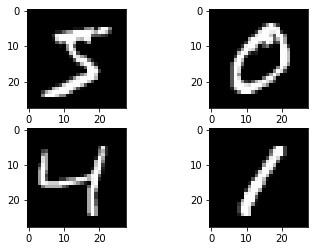

(28, 28)


In [0]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
(X_train, y_train), (X_test, y_test) = mnist.load_data()
plt.subplot(221)
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()
print(X_train[0].shape)

**Download train and test csv files**

In [0]:
!wget https://www.python-course.eu/data/mnist/mnist_train.csv

--2020-03-17 04:51:16--  https://www.python-course.eu/data/mnist/mnist_train.csv
Resolving www.python-course.eu (www.python-course.eu)... 138.201.17.115, 2a01:4f8:171:286f::4
Connecting to www.python-course.eu (www.python-course.eu)|138.201.17.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109575994 (104M) [text/csv]
Saving to: ‘mnist_train.csv’

mnist_train.csv     100%[===================>] 104.50M  18.8MB/s    in 6.7s    

2020-03-17 04:51:24 (15.7 MB/s) - ‘mnist_train.csv’ saved [109575994/109575994]



In [0]:
!wget https://www.python-course.eu/data/mnist/mnist_test.csv

--2020-03-17 04:51:25--  https://www.python-course.eu/data/mnist/mnist_test.csv
Resolving www.python-course.eu (www.python-course.eu)... 138.201.17.115, 2a01:4f8:171:286f::4
Connecting to www.python-course.eu (www.python-course.eu)|138.201.17.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18289443 (17M) [text/csv]
Saving to: ‘mnist_test.csv’

mnist_test.csv      100%[===================>]  17.44M  9.32MB/s    in 1.9s    

2020-03-17 04:51:28 (9.32 MB/s) - ‘mnist_test.csv’ saved [18289443/18289443]



In [0]:

if True:  # recreate MNIST arrays. Do it only once, after that modify to False
    train_data = np.loadtxt("mnist_train.csv", delimiter=",")
    test_data = np.loadtxt("mnist_test.csv", delimiter=",")
    train_imgs = np.asfarray(train_data[:, 1:]) / 255.0
    test_imgs = np.asfarray(test_data[:, 1:]) / 255.0
    train_labels = np.asfarray(train_data[:, :1])
    test_labels = np.asfarray(test_data[:, :1])
    lr = np.arange(10)
    train_labels_one_hot = (lr==train_labels).astype(np.float)
    test_labels_one_hot = (lr==test_labels).astype(np.float)
    for i, d in enumerate([train_imgs, test_imgs, train_labels, test_labels, train_labels_one_hot, test_labels_one_hot]):
        np.save('%i.array' % i, d)

(train_imgs, test_imgs, train_labels, test_labels, train_labels_one_hot, test_labels_one_hot) = [np.load('%i.array.npy' % i) for i in range(6)]

print('Data loaded.')

if False:  # show images
    for i in range(10):
        img = train_imgs[i].reshape((28,28))
        plt.imshow(img, cmap="Greys")
        plt.show()

Data loaded.


In [0]:
class NeuralNetwork:
    def __init__(self, network_structure, learning_rate, bias=None):  
        self.structure = network_structure
        self.no_of_layers = len(self.structure)
        self.learning_rate = learning_rate 
        self.bias = bias
        self.create_weight_matrices()

    def create_weight_matrices(self):
        bias_node = 1 if self.bias else 0
        self.weights_matrices = []
        for k in range(self.no_of_layers-1):
            nodes_in = self.structure[k]
            nodes_out = self.structure[k+1]
            n = (nodes_in + bias_node) * nodes_out
            X = truncnorm(-1, 1,  loc=0, scale=1)
            #X = truncnorm(-1 / np.sqrt(nodes_in), 1 / np.sqrt(nodes_in),  loc=0, scale=1)  # accuracy is worse
            wm = X.rvs(n).reshape((nodes_out, nodes_in + bias_node))
            self.weights_matrices.append(wm)

    def train(self, input_vector, target_vector): 
        input_vector = np.array(input_vector, ndmin=2).T
        res_vectors = [input_vector]
        for k in range(self.no_of_layers-1):
            in_vector = res_vectors[-1]
            if self.bias:
                in_vector = np.concatenate((in_vector, [[self.bias]]))
                res_vectors[-1] = in_vector
            x = np.dot(self.weights_matrices[k], in_vector)
            out_vector = activation_function(x)
            res_vectors.append(out_vector)    

        target_vector = np.array(target_vector, ndmin=2).T
        output_errors = target_vector - out_vector  
        for k in range(self.no_of_layers-1, 0, -1):
            out_vector = res_vectors[k]
            in_vector = res_vectors[k-1]
            if self.bias and not k==(self.no_of_layers-1):
                out_vector = out_vector[:-1,:].copy()
            tmp = output_errors * out_vector * (1.0 - out_vector)  # sigma'(x) = sigma(x) (1 - sigma(x))
            tmp = np.dot(tmp, in_vector.T)
            self.weights_matrices[k-1] += self.learning_rate * tmp
            output_errors = np.dot(self.weights_matrices[k-1].T, output_errors)
            if self.bias:
                output_errors = output_errors[:-1,:]

    def run(self, input_vector):
        if self.bias:
            input_vector = np.concatenate((input_vector, [self.bias]))
        in_vector = np.array(input_vector, ndmin=2).T
        for k in range(self.no_of_layers-1):
            x = np.dot(self.weights_matrices[k], in_vector)
            out_vector = activation_function(x)
            in_vector = out_vector
            if self.bias:
                in_vector = np.concatenate((in_vector, [[self.bias]]))
        return out_vector

    def evaluate(self, data, labels):
        corrects, wrongs = 0, 0
        for i in range(len(data)):
            res = self.run(data[i])
            res_max = res.argmax()
            if res_max == labels[i]:
                corrects += 1
            else:
                wrongs += 1
        return corrects, wrongs

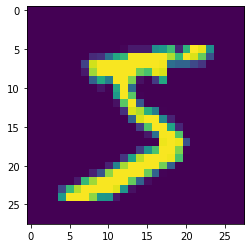

In [0]:
X_train_plot_0 = train_imgs[0].reshape(-1,28,28,1)
plt.imshow(X_train_plot_0[0][:,:,0])

In [0]:
# define the NeuralNetwork class object
ANN = NeuralNetwork(network_structure=[784, 300, 74, 10], learning_rate=0.1, bias=None)

In [0]:
# Train the ANN object for 3 epochs
for epoch in tqdm(range(3)):
    for i in range(len(train_imgs)):
        if i % 1000 == 0:
            print('epoch:', epoch, 'img number:', i, '/', len(train_imgs))
        ANN.train(train_imgs[i], train_labels_one_hot[i])

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 0 img number: 0 / 60000
epoch: 0 img number: 1000 / 60000
epoch: 0 img number: 2000 / 60000
epoch: 0 img number: 3000 / 60000
epoch: 0 img number: 4000 / 60000
epoch: 0 img number: 5000 / 60000
epoch: 0 img number: 6000 / 60000
epoch: 0 img number: 7000 / 60000
epoch: 0 img number: 8000 / 60000
epoch: 0 img number: 9000 / 60000
epoch: 0 img number: 10000 / 60000
epoch: 0 img number: 11000 / 60000
epoch: 0 img number: 12000 / 60000
epoch: 0 img number: 13000 / 60000
epoch: 0 img number: 14000 / 60000
epoch: 0 img number: 15000 / 60000
epoch: 0 img number: 16000 / 60000
epoch: 0 img number: 17000 / 60000
epoch: 0 img number: 18000 / 60000
epoch: 0 img number: 19000 / 60000
epoch: 0 img number: 20000 / 60000
epoch: 0 img number: 21000 / 60000
epoch: 0 img number: 22000 / 60000
epoch: 0 img number: 23000 / 60000
epoch: 0 img number: 24000 / 60000
epoch: 0 img number: 25000 / 60000
epoch: 0 img number: 26000 / 60000
epoch: 0 img number: 27000 / 60000
epoch: 0 img number: 28000 / 6000

 33%|███▎      | 1/3 [01:25<02:50, 85.30s/it]

epoch: 1 img number: 0 / 60000
epoch: 1 img number: 1000 / 60000
epoch: 1 img number: 2000 / 60000
epoch: 1 img number: 3000 / 60000
epoch: 1 img number: 4000 / 60000
epoch: 1 img number: 5000 / 60000
epoch: 1 img number: 6000 / 60000
epoch: 1 img number: 7000 / 60000
epoch: 1 img number: 8000 / 60000
epoch: 1 img number: 9000 / 60000
epoch: 1 img number: 10000 / 60000
epoch: 1 img number: 11000 / 60000
epoch: 1 img number: 12000 / 60000
epoch: 1 img number: 13000 / 60000
epoch: 1 img number: 14000 / 60000
epoch: 1 img number: 15000 / 60000
epoch: 1 img number: 16000 / 60000
epoch: 1 img number: 17000 / 60000
epoch: 1 img number: 18000 / 60000
epoch: 1 img number: 19000 / 60000
epoch: 1 img number: 20000 / 60000
epoch: 1 img number: 21000 / 60000
epoch: 1 img number: 22000 / 60000
epoch: 1 img number: 23000 / 60000
epoch: 1 img number: 24000 / 60000
epoch: 1 img number: 25000 / 60000
epoch: 1 img number: 26000 / 60000
epoch: 1 img number: 27000 / 60000
epoch: 1 img number: 28000 / 6000

 67%|██████▋   | 2/3 [02:50<01:25, 85.31s/it]

epoch: 2 img number: 0 / 60000
epoch: 2 img number: 1000 / 60000
epoch: 2 img number: 2000 / 60000
epoch: 2 img number: 3000 / 60000
epoch: 2 img number: 4000 / 60000
epoch: 2 img number: 5000 / 60000
epoch: 2 img number: 6000 / 60000
epoch: 2 img number: 7000 / 60000
epoch: 2 img number: 8000 / 60000
epoch: 2 img number: 9000 / 60000
epoch: 2 img number: 10000 / 60000
epoch: 2 img number: 11000 / 60000
epoch: 2 img number: 12000 / 60000
epoch: 2 img number: 13000 / 60000
epoch: 2 img number: 14000 / 60000
epoch: 2 img number: 15000 / 60000
epoch: 2 img number: 16000 / 60000
epoch: 2 img number: 17000 / 60000
epoch: 2 img number: 18000 / 60000
epoch: 2 img number: 19000 / 60000
epoch: 2 img number: 20000 / 60000
epoch: 2 img number: 21000 / 60000
epoch: 2 img number: 22000 / 60000
epoch: 2 img number: 23000 / 60000
epoch: 2 img number: 24000 / 60000
epoch: 2 img number: 25000 / 60000
epoch: 2 img number: 26000 / 60000
epoch: 2 img number: 27000 / 60000
epoch: 2 img number: 28000 / 6000

100%|██████████| 3/3 [04:16<00:00, 85.38s/it]


In [0]:
corrects, wrongs = ANN.evaluate(test_imgs, test_labels)
print("accruracy: test", corrects / (corrects + wrongs))

accruracy: test 0.9171
